In [5]:
%matplotlib inline

import numpy as np

from numpy.random import choice, normal

import matplotlib.pyplot as plt
import matplotlib.dates as md

from itertools import cycle

import pds4_tools as pds
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from scipy.stats import median_abs_deviation as mad

from local_utils import *

str2date = lambda x: datetime.strptime(x, '00133M%H:%M:%S.%f')
str2dates = lambda xs: [str2date(xs[i]) for i in range(len(xs))]

# print(str2date('00133M00:00:28.824').microsecond)
print(str2dates(['00133M00:00:28.824', '00133M00:00:29.311', '00133M00:00:29.797']))

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

kappa = 0.4

[datetime.datetime(1900, 1, 1, 0, 0, 28, 824000), datetime.datetime(1900, 1, 1, 0, 0, 29, 311000), datetime.datetime(1900, 1, 1, 0, 0, 29, 797000)]


In [8]:
def calculate_scaled_windspeed(windspeeds_to_scale, z, zstar, z0=150.):
    """
    Returns wind speed time series scaled as if it were measured at a different elevation,
    assuming a logarithmic wind profile
    
    Args:
        windspeeds_to_scale (float array): wind speeds to scale
        z (float): altitude at which measurement is assumed to take place
        zstar (float): the roughness scale - https://en.wikipedia.org/wiki/Roughness_length
        z0 (float, optional): altitude at which actual wind speed measurement was made; defaults to 1.5 meters
        kappa (float, optional): von Karman parameter; defaults to 0.4
    
    Returns:
        Scaled wind speed time series
    
    """
    
    # Calculate ustar assuming average windspeeds_to_scale
    return windspeeds_to_scale*np.log(z/zstar)/np.log(z0/zstar)

def retrieve_relevant_times(time, t0, sample_time):
    return (t0 <= time) & (time <= t0 + sample_time)

def sample_wind_profile(sample_time, t0, time, windspeeds, heights):
    """
    Return wind speeds from four height sampled over the given sample time
    
    Args:
        sample_time (float): time over which to average in seconds
        t0 (float, optional): time at which at start averages
        times (float array): measured times
        windspeeds (dict of float arrays): wind speed time-series referenced by anemometer height
    
    Returns:
        Wind speeds averaged for sample time from different anemometer times series, one after another
    """
    
    # Run through each height, assuming the first one in windspeeds is the lowest and on up
    cur_t0 = t0
    averaged_windspeeds = np.zeros_like(heights)
    std_windspeeds = np.zeros_like(heights)
    for i in range(len(heights)):
        ind = retrieve_relevant_times(time, cur_t0, sample_time) 
        
        averaged_windspeeds[i] = np.mean(windspeeds[str(heights[i])][ind])
        std_windspeeds[i] = np.std(windspeeds[str(heights[i])][ind])/\
            (np.sqrt(len(windspeeds[str(heights[i])][ind]) - 1.))
        
#         std_windspeeds[i] = 1.4826*mad(windspeeds[str(heights[i])][ind])/\
#             (np.sqrt(len(windspeeds[str(heights[i])][ind]) - 1.))

        cur_t0 += sample_time
        
    return averaged_windspeeds, std_windspeeds

def calc_num_points(sample_time, sampling):
    return np.floor(sample_time/sampling)

struct_list = pds.read('WE__0133___________DER_WS__________________P01.xml')
print(struct_list)

Processing label: WE__0133___________DER_WS__________________P01.xml
Now processing a Header structure: HEADER
Now processing a Table_Delimited structure: TABLE
<StructureList at 0x7fd9298db760> with:
<HeaderStructure 'HEADER' at 0x7fd94aba9840>
<TableStructure 'TABLE' at 0x7fd9298d9ea0>


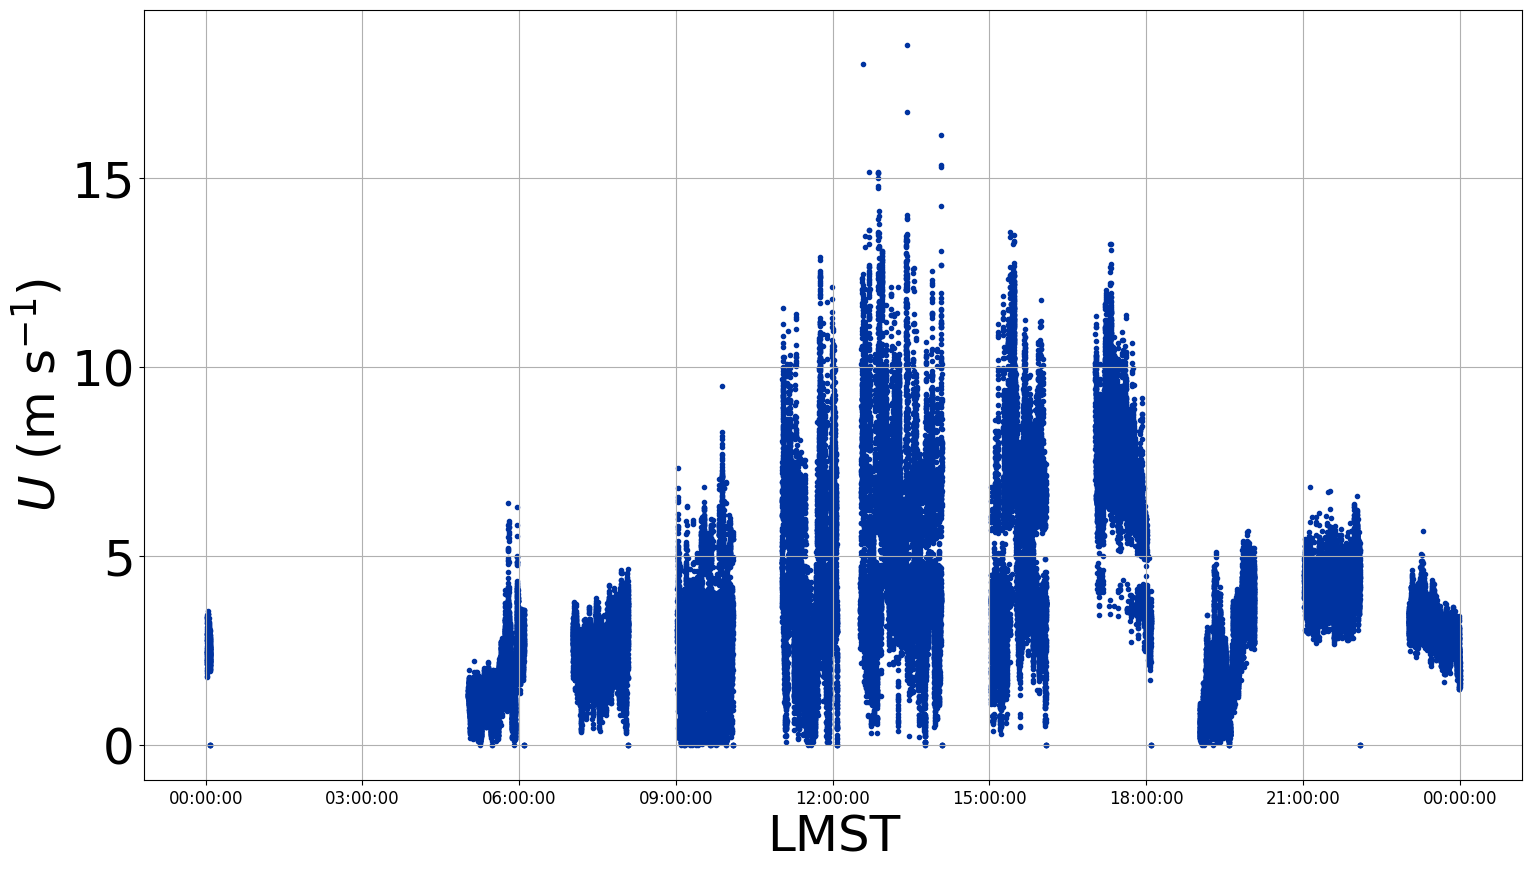

In [91]:
# When during the day should you fly?
# In terms of times after sunrise, probably between 6 and 9am.

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)

ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999)
time = np.array(str2dates(struct_list['TABLE']['LMST']))

# ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999) &\
#         (time > datetime(1900, 1, 1, 7, 0, 0)) & (time < datetime(1900, 1, 1, 8, 0, 0))

# ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999) &\
#         (time > datetime(1900, 1, 1, 9, 0, 0)) & (time < datetime(1900, 1, 1, 10, 0, 0))

time = np.array(str2dates(struct_list['TABLE']['LMST']))[ind]
wind = np.array(struct_list['TABLE']['HORIZONTAL_WIND_SPEED'][ind])

ax.scatter(time, wind, marker='.', color=BoiseState_blue)

xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.grid(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=36)
ax.set_xlabel("LMST", fontsize=36)
ax.set_ylabel(r'$U\ \left( {\rm m\ s^{-1}} \right)$', fontsize=36)

fig.savefig("Sol133_Windspeeds.jpg", dpi=300, bbox_inches="tight")

saved_ustar, saved_zstar:  28.989561029006804 3.0
ustar +- sigma_ustar, zstar +- sigma_zstar:  34.46716539159864 2.3119200814515257 2.7189123160363486 0.7240585727240266


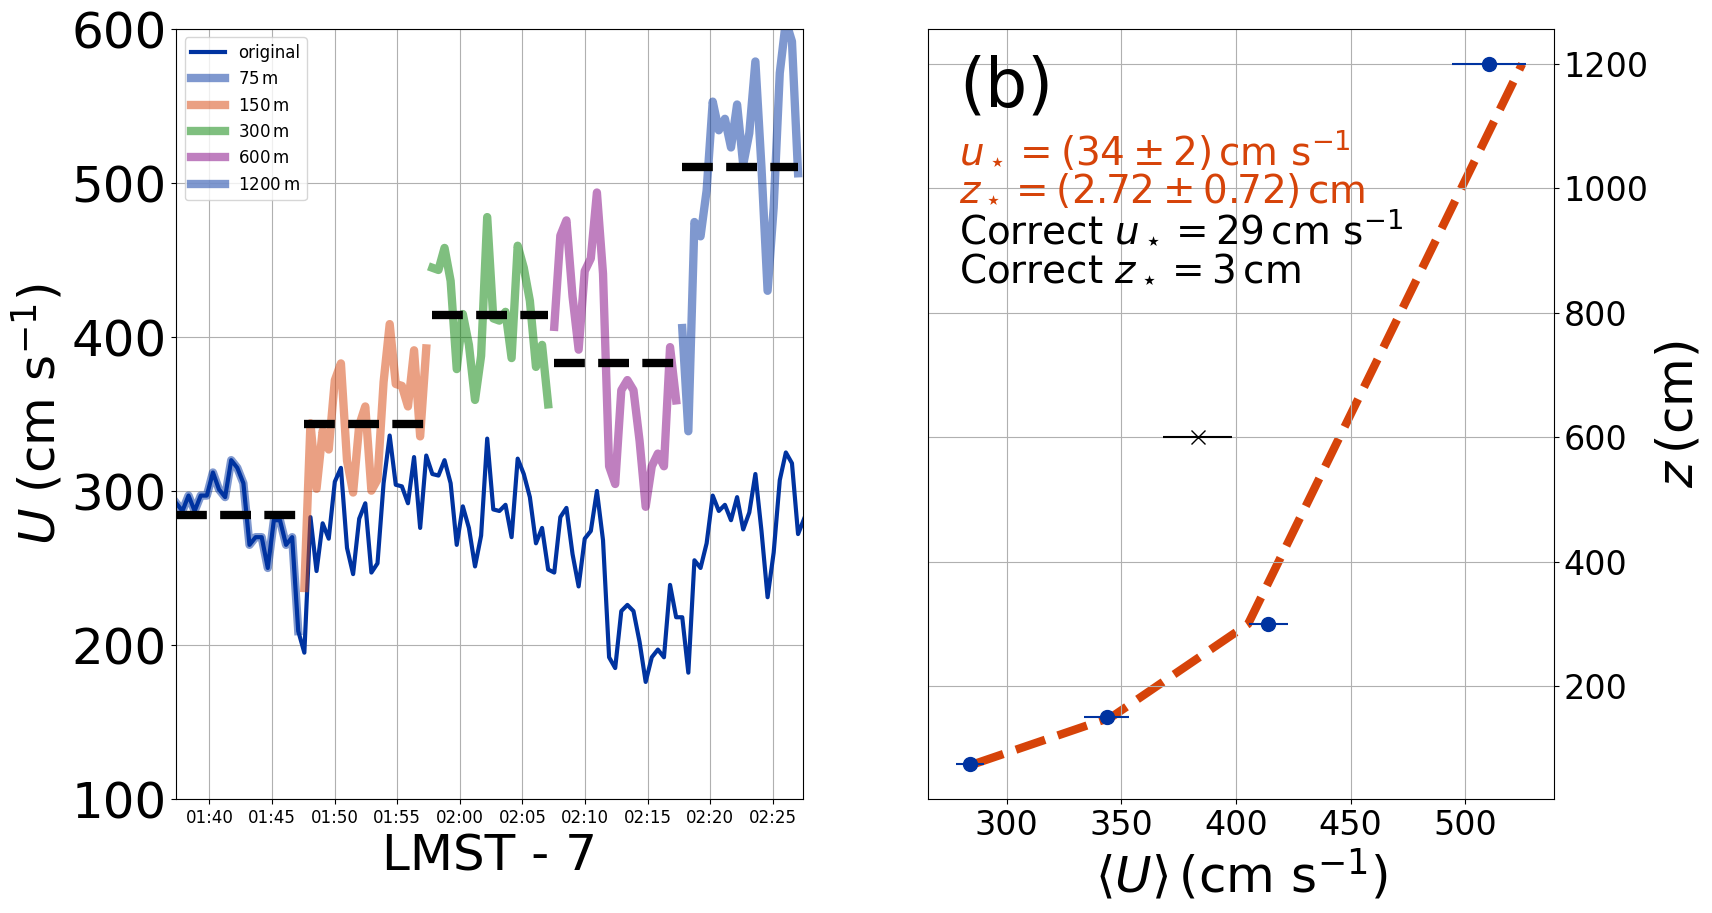

In [101]:
colors = cycle([BoiseState_blue, BoiseState_orange, "green", "purple"])
linestyles = cycle(['solid', 'dashed', 'dashdot', 'dotted'])

time = np.array(str2dates(struct_list['TABLE']['LMST']))
# Prepare to add some noise
ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999)
sigma = np.std(struct_list['TABLE']['HORIZONTAL_WIND_SPEED'][ind])*100 #m/s to cm/s

# ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999) &\
#         (time > datetime(1900, 1, 1, 11, 0, 0)) & (time < datetime(1900, 1, 1, 12, 0, 0))

# Between 7 and 8 a - 11a-12p is too gusty!
# ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999) &\
#         (time > datetime(1900, 1, 1, 7, 0, 0)) & (time < datetime(1900, 1, 1, 8, 0, 0))

ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999) &\
        (time > datetime(1900, 1, 1, 7, 0, 0)) & (time < datetime(1900, 1, 1, 8, 0, 0))

# ind = (struct_list['TABLE']['HORIZONTAL_WIND_SPEED'] != 999999999) &\
#         (time > datetime(1900, 1, 1, 9, 0, 0)) & (time < datetime(1900, 1, 1, 10, 0, 0))

time = time[ind]
wind = np.array(struct_list['TABLE']['HORIZONTAL_WIND_SPEED'])[ind]

fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sampling_duration = 10.
# zs = np.array([150., 300., 600., 1200.]) # cm
# zs = np.array([100., 200., 300., 400., 500., 600., 700., 800., 900., 1000.]) # cm
# zs = np.array([10., 20., 30., 40., 50., 60., 70., 80., 90., 100.]) + 100. # cm
zs = np.array([75., 150., 300., 600., 1200.]) # cm
delta_x = np.log(2)
saved_zstar = 3. # cm
saved_ustar = kappa*np.mean(struct_list['TABLE']['HORIZONTAL_WIND_SPEED'][ind]*100)/np.log(zs[0]/saved_zstar)
print("saved_ustar, saved_zstar: ", saved_ustar, saved_zstar)

scaled_windspeeds = {}
noisy_scaled_windspeeds = {}

for i in range(len(zs)):    
    scaled_windspeeds[str(zs[i])] =\
        calculate_scaled_windspeed(struct_list['TABLE']['HORIZONTAL_WIND_SPEED'][ind]*100, zs[i], saved_zstar, 
                                  z0=np.min(zs))
    
    # And add in the noise
    noisy_scaled_windspeeds[str(zs[i])] = scaled_windspeeds[str(zs[i])]# +\
#         normal(scale=sigma, size=len(scaled_windspeeds[str(zs[i])]))

### Synthetic wind profile ###
ax1.plot(time, wind*100, lw=3, color=BoiseState_blue, label="original")

t0 = np.min(time)
cur_t0 = t0
sample_time = timedelta(seconds=sampling_duration)
averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_time, t0, time, noisy_scaled_windspeeds, zs)

for i in range(len(zs)):
    which_wind = i
    ind = retrieve_relevant_times(time, cur_t0, sample_time)
    cur_color = next(colors)
    ax1.plot(time[ind], noisy_scaled_windspeeds[str(zs[which_wind])][ind], 
             label=r'$%g\, {\rm m}$' % zs[which_wind], lw=6, color=cur_color, alpha=0.5)
    ax1.plot([np.min(time[ind]), np.max(time[ind])], 
             [averaged_windspeeds[which_wind], averaged_windspeeds[which_wind]], lw=6, ls='--', color='k')
    cur_t0 += sample_time    

xfmt = md.DateFormatter('%M:%S')
ax1.xaxis.set_major_formatter(xfmt)
ax1.grid(True)
ax1.tick_params(axis="x", labelsize=12)
ax1.tick_params(axis="y", labelsize=36)
ax1.set_xlabel("LMST - 7", fontsize=36)
ax1.set_ylabel(r'$U\ \left( {\rm cm\ s^{-1}} \right)$', fontsize=36)
ax1.legend(loc='best', fontsize=12)
ax1.set_xlim([np.min(time), np.min(time) + timedelta(seconds=len(zs)*sampling_duration)])
ax1.set_ylim([100, 600])

### Fit synthetic wind profile ###

# Toss points that are trended in the wrong way
inlier_zs = zs[0]
inlier_averaged_windspeeds = averaged_windspeeds[0]
inlier_std_windspeeds = std_windspeeds[0]

outlier_zs = np.array([])
outlier_averaged_windspeeds = np.array([])
outlier_std_windspeeds = np.array([])

for i in range(1, len(zs)):
    if(np.all(averaged_windspeeds[i] > averaged_windspeeds[0:i])):
        inlier_zs = np.append(inlier_zs, zs[i])
        inlier_averaged_windspeeds = np.append(inlier_averaged_windspeeds, averaged_windspeeds[i])
        inlier_std_windspeeds = np.append(inlier_std_windspeeds, std_windspeeds[i])
    else:
        outlier_zs = np.append(outlier_zs, zs[i])
        outlier_averaged_windspeeds = np.append(outlier_averaged_windspeeds, averaged_windspeeds[i])
        outlier_std_windspeeds = np.append(outlier_std_windspeeds, std_windspeeds[i])        
        
zs = inlier_zs
averaged_windspeeds = inlier_averaged_windspeeds
std_windspeeds = inlier_std_windspeeds

y = averaged_windspeeds
log_z = np.log(zs/np.min(zs))
yerr = std_windspeeds
popt, pcov = curve_fit(lin_fit, log_z, y, sigma=yerr)
unc = np.sqrt(np.diag(pcov))
        
# And now let's toss outliers
num_sigma = 5.
inliers = np.abs(y - np.polyval(popt, log_z))/yerr <= num_sigma
y = averaged_windspeeds[inliers]
log_z = np.log(zs[inliers]/np.min(zs[inliers]))
yerr = std_windspeeds[inliers]
popt, pcov = curve_fit(lin_fit, log_z, y, sigma=yerr)
unc = np.sqrt(np.diag(pcov))

if(len(averaged_windspeeds[~inliers]) > 0):
    outlier_zs = np.append(outlier_zs, zs[~inlier])
    outlier_averaged_windspeeds = np.append(outlier_averaged_windspeeds, averaged_windspeeds[~inlier])
    outlier_std_windspeeds = np.append(outlier_std_windspeeds, std_windspeeds[~inlier])        
    
# Force chi^2 = 1    
unc_scaling = np.sqrt(chisqg(y, np.polyval(popt, log_z), sd=yerr)/(len(zs) - 2))
unc *= unc_scaling
yerr *= unc_scaling

ax2.errorbar(averaged_windspeeds[inliers], zs[inliers], 
     xerr=std_windspeeds[inliers]*unc_scaling,
     marker='o', markersize=10, color=BoiseState_blue, ls='')
# Show tossed points
ax2.errorbar(outlier_averaged_windspeeds, outlier_zs, 
     xerr=outlier_std_windspeeds*unc_scaling,
     marker='x', markersize=10, color='k', ls='')

ustar = calc_ustar_from_slope(kappa, popt[0])
zstar = calc_zstar_from_slope_and_intercept(np.min(zs), popt[0], popt[1])

sigma_ustar = 0.4*unc[0]
sigma_zstar = zstar*popt[1]/popt[0]*np.sqrt((unc[0]/popt[0])**2 + (unc[1]/popt[1])**2 - 2*pcov[1,0]/popt[0]/popt[1])
print("ustar +- sigma_ustar, zstar +- sigma_zstar: ", ustar, sigma_ustar, zstar, sigma_zstar)

log_z = np.log(zs/np.min(zs))
ax2.plot(np.polyval(popt, log_z), zs, lw=6, color=BoiseState_orange, ls='--', zorder=-1)
ax2.text(0.05, 0.90, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.text(0.05, 0.825, r'$u_\star = \left( %.0f\pm%.0f \right)\,{\rm cm\ s^{-1}}$' % (ustar, sigma_ustar), 
         fontsize=28, transform=ax2.transAxes, color=BoiseState_orange)
ax2.text(0.05, 0.775, r'$z_\star = \left( %.2f\pm%.2f \right)\,{\rm cm}$' % (zstar, sigma_zstar), 
         fontsize=28, transform=ax2.transAxes, color=BoiseState_orange)

ax2.text(0.05, 0.725, r'Correct $u_\star = %.0f\, {\rm cm\ s^{-1}}$' % (saved_ustar), 
         fontsize=28, transform=ax2.transAxes)
ax2.text(0.05, 0.675, r'Correct $z_\star = %.0f\, {\rm cm}$' % (saved_zstar), 
         fontsize=28, transform=ax2.transAxes)

ax2.grid(True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax2.tick_params(labelsize=24)
ax2.set_xlabel(r'$\langle U \rangle \, \left( {\rm cm\ s^{-1} } \right)$', fontsize=36)
ax2.set_ylabel(r'$z\, \left( {\rm cm } \right)$', fontsize=36)
ax2.grid(True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

fig.savefig("Synthetic_Mars_Wind_Profile.jpg", dpi=300, bbox_inches="tight")